# Access tri-seasonal Sentinel-1 SAR composites on Google Earth Engine and transfer locally
Paul Montesano  
Oct 2023  
NASA Goddard Space Flight Center  
Multi-Mission Algorithm and Analysis Platform (MAAP) | https://www.earthdata.nasa.gov/esds/maap
#### An example of running a script to transfer a Google Earth Engine asset to a local dir

In [1]:
import ee
import os, sys

# This repo needed to run this notebook
# https://github.com/lauraduncanson/icesat2_boreal.git
# which contains 
# https://github.com/lauraduncanson/icesat2_boreal/blob/master/lib/ee_download.py
# https://github.com/lauraduncanson/icesat2_boreal/blob/master/lib/do_gee_download_by_subtile.py

# Add the subdir of this repo where the script is located to your PATH variable.
sys.path.append('/projects/code/icesat2_boreal/lib')
import do_gee_download_by_subtile

import rasterio
from rasterio.plot import show_hist, show
import numpy as np
import matplotlib.pyplot as plt
import shapely
import pandas as pd
import geopandas as gpd
import glob

import shapely
import folium

### Make vector subtile fishnet for GEE (aggregate) tile of interest

Note: here you can explore the TILE_SIZE_M value that you want to optimize for transfer out of GEE

In [5]:
def get_gee_assets(asset_path):
    
    # fetch EE assets
    COLL_ID = asset_path
    try:
        collection = ee.ImageCollection(COLL_ID)
        collection_items = collection.toList(1000).getInfo()
    except EEError as e
        collection_items = ee.Image(ASSET_PATH).getInfo()
    # tranlsate collection to df
    collection_items_df = pd.DataFrame.from_dict(collection_items)

    return collection_items_df

In [29]:
ASSET_PATH = 'projects/foreststructure/TTE_DATA_v201902v2'

collection_items = ee.Image(ASSET_PATH).getInfo()
collection_items_df = pd.DataFrame.from_dict(collection_items['properties'])
geom_list = [shapely.Polygon(collection_items_df['system:footprint']['coordinates']) ]
gdf = gpd.GeoDataFrame(collection_items_df.drop(columns=['system:footprint']),  geometry=geom_list, crs=4326)
gdf.explore(height=500, width=1000, color='red', name=f'All agg tiles from GEE asset')

ValueError: Length of values (1) does not match length of index (2)

In [28]:
collection_items_df

,system:footprint,system:asset_size
coordinates,"[[-180, -90], [180, -90], [180, 90], [-180, 90...",55407496384
type,LinearRing,55407496384


In [31]:
collection_items_df = pd.DataFrame.from_dict(collection_items['properties'])

collection_items_df.head()

,system:footprint,system:asset_size
coordinates,"[[-180, -90], [180, -90], [180, 90], [-180, 90...",55407496384
type,LinearRing,55407496384


In [16]:
pd.DataFrame(collection_items)

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [2]:


#### If DPSing by subtile, you need ASSET_PATH to get gee asset_df and TILELOC to get the tile form asset_df to make its fishnet even before you call 'do_gee_download_by_subtile'
ASSET_PATH = 'projects/foreststructure/Circumboreal/S1_Composites_albers'


# We need this asset_df to know how to loop over asset tiles - but the script also needs it during processing and to use it to build a fishnet_df 
asset_df = do_gee_download_by_subtile.get_gee_assets(ASSET_PATH)
asset_df = pd.concat([asset_df.drop(['properties'], axis=1), asset_df['properties'].apply(pd.Series)], axis=1) # makes the AGG_TILE_NUM field available

DPS_ASSET_TILE_LIST = asset_df.index.to_list()
DPS_ASSET_TILE_LIST = sorted(asset_df[TILE_FIELD_NAME].to_list()) # this field now available


def make_asset_tile_subtiles(AGG_TILE_NUM, asset_df):
    ASSET_TILE = DPS_ASSET_TILE_LIST.index(AGG_TILE_NUM+1)

    ASSET_TILE_NAME = os.path.basename(asset_df[asset_df[TILE_FIELD_NAME]==ASSET_TILE].id.to_list()[0])

    # 
    # Get fishnet of subtiles on the fly to DPS subtile submission
    #
    fishnet_df = do_gee_download_by_subtile.create_fishnet(asset_df[asset_df[TILE_FIELD_NAME] == ASSET_TILE], TILE_SIZE_M)
    fishnet_df['subtile'] = fishnet_df.index
    fishnet_df['tile'] = ASSET_TILE

    fishnet_4326 = fishnet_df.to_crs("EPSG:4326")
    
    return fishnet_4326

EEException: ImageCollection.load: Expected asset 'projects/foreststructure/TTE_DATA_v201902v2' to be an ImageCollection, found 'Image'.

In [57]:

AGG_TILE_NUM = 85
TILE_FIELD_NAME = 'AGG_TILE_NUM'
TILE_SIZE_M = 600

# Subtile arrangement obv will change with the tile size
# Set some subtiles that will work here
if AGG_TILE_NUM == 85 and TILE_SIZE_M == 500: 
    SUBTILE = 2631
if AGG_TILE_NUM == 85 and TILE_SIZE_M == 600: 
    SUBTILE = 1747
if AGG_TILE_NUM == 85 and TILE_SIZE_M == 750: 
    SUBTILE = 1185
    
fishnet_4326 = make_asset_tile_subtiles(AGG_TILE_NUM, asset_df)

### Map the vectors

In [52]:
# The geodataframe built from the GEE asset footprint seems to have funky geometry
geom_list = [shapely.Polygon(asset_df['system:footprint'][x]['coordinates']) for x in asset_df.index.to_list()]
gdf = gpd.GeoDataFrame(asset_df.drop(columns=['id','type','version','bands','system:footprint']),  geometry=geom_list, crs=4326)
m = gdf.explore(height=500, width=1000, color='red', name=f'All agg tiles from GEE asset')

# This gpkg seems to have the correct geometry
agg_tiles_gdf = gpd.read_file('/projects/my-public-bucket/databank/boreal_tiles_v003_agg9.gpkg')
m = agg_tiles_gdf.explore(m=m, name=f'All agg tiles from local gpkg')

# Show the subtiles for a single aggregate (AGG) tile
m = fishnet_4326.explore(m=m, color='black', style_kwds=dict(color="black",  weight=1, opacity=0.4, fillOpacity=0), legend=True, name=f'Subtiles for agg tile: {AGG_TILE_NUM}')
folium.LayerControl().add_to(m)
print(len(fishnet_4326))
m

2209


### Run a single asset transfer
Transfer a subtile (of some pre-determined size) of a ***tri-seasonal composite*** of `gamma-nought` (RTC) `Sentinel 1` SAR scenes from 2018  

Seasonal grouping of scenes:
 - frozen (Jan-March)  
 - summer (June-August)  
 - shoulder (Sept-Oct)
 
In the high latitudes, seasonal SAR composites may reveal key differences in land covers as they change through freeze/thaw seasonal periods. These differences may be useful for mapping forest structure patterns across the boreal forest domain.

In [48]:
try:
    do_gee_download_by_subtile.do_gee_download_by_subtile(SUBTILE_LOC=SUBTILE, 
                                                      ID_NUM=AGG_TILE_NUM, 
                                                      ID_COL='AGG_TILE_NUM', 
                                                      ASSET_PATH='projects/foreststructure/Circumboreal/S1_Composites_albers', 
                                                      TILE_SIZE_M=TILE_SIZE_M, 
                                                      OUTDIR='/projects/my-public-bucket/do_gee_download_by_subtile_TEST'
                                                     )
except Exception as e:
    
    if 'Total request size' in e.args[0] : print(f'\nSubtile size {TILE_SIZE_M} too large for GEE asset transfer')


	Subtile 1747 for AGG_TILE_NUM # 85 (s1_vv_vh_gamma_2018_pwr_tile85) to subdir: /projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile85
	SUBTILE_LOC: 1747 : extracted tifs to /projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile85-subtile001747


### Collect output files

In [49]:
fn_list = glob.glob(f'/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile{AGG_TILE}-subtile{int(SUBTILE):06}/*.tif')
fn_list

['/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile85-subtile001747/s1_vv_vh_gamma_2018_pwr_tile85.VH_median_frozen-subtile001747.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile85-subtile001747/s1_vv_vh_gamma_2018_pwr_tile85.VH_median_shoulder-subtile001747.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile85-subtile001747/s1_vv_vh_gamma_2018_pwr_tile85.VH_median_summer-subtile001747.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile85-subtile001747/s1_vv_vh_gamma_2018_pwr_tile85.VV_median_frozen-subtile001747.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile85-subtile001747/s1_vv_vh_gamma_2018_pwr_tile85.VV_median_shoulder-subtile001747.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile85-subtile001747/s1_vv_vh_gamma_2018_

### Plot a multiband composite

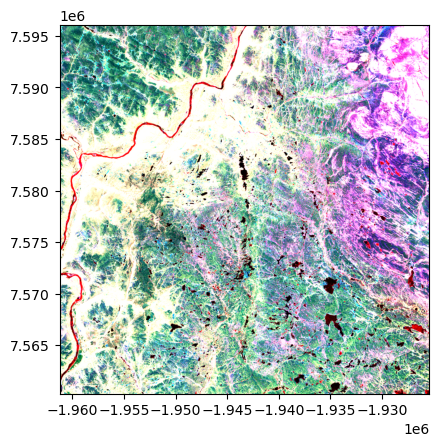

In [50]:
outdir = os.path.dirname(fn_list[2])
multiband_fn = os.path.join(outdir, 'multi_band_temp.tif')

def pct_clip(array, pct=[1,80]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

with rasterio.open(fn_list[0]) as src1:
    with rasterio.open(fn_list[2]) as src2:
        with rasterio.open(fn_list[5]) as src3:
            
            arr1 = src1.read(1)
            arr2 = src2.read(1)
            arr3 = src3.read(1)
            with rasterio.open(multiband_fn, 'w+',
                    driver='GTiff',
                    dtype= rasterio.float32,
                    count=3,
                    crs = src1.crs,
                    width=src1.width,
                    height=src1.height,
                    transform=src1.transform,
                ) as dst:
                V = pct_clip(src1.read(1), pct=[1,60])
                dst.write(V,1)
                V = pct_clip(src2.read(1), pct=[1,70])
                dst.write(V,2)
                V = pct_clip(src3.read(1), pct=[1,75])
                dst.write(V,3)
                
fig,ax=plt.subplots()
with rasterio.open(multiband_fn) as src:
    show(src.read(),transform=src.transform,ax=ax)
    bounds  = src.bounds

In [58]:
gdf = gpd.GeoDataFrame({"id":1,"geometry":[shapely.geometry.box(*bounds)]}, crs=src.crs)
gdf.to_crs(4326).explore(height=300, width = 500)